In [1]:
import pandas
import matplotlib.pyplot as plt
import matplotlib.dates as md

import random
import seaborn as sns
import numpy as np
from pykalman import KalmanFilter
from pykalman import UnscentedKalmanFilter
from IPython.display import Image
from matplotlib import axes

from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error, r2_score

import csv

In [2]:
def convert_ts_to_datetime(ts_series):
    """
    This function converts timestamps into datetime objects

    Parameters
    ----------
    ts_series : Pandas Series of timestamps

    Returns
    ----------
    datetime_series : Pandas Series of strings of datetimes

    Notes
    -----
    This function can accept these ts units: s, ms, us, ns
    """

    available_units = {19:'ns', 16:'us', 13:'ms', 10:'s'}
    time_zone = 'Asia/Hong_Kong'

    def _epoch_time_converter(t):
        t = str(t)
        if len(t) in available_units.keys():
            unit = available_units[len(t)]
        else:
            raise AttributeError('{} is not in valid epoch time format'.format(t))
        return pandas.to_datetime(t, unit=unit, utc=True).tz_convert(time_zone)

    digits = ts_series.astype(str).str.len()
    # only one unit of ts is in the whole series,
    # so use vectorized method to convert
    if len(digits.unique()) == 1:
        if digits.iloc[0] in available_units.keys():
            unit_of_ts = available_units[digits.iloc[0]]
            datetime_series = pandas.to_datetime(ts_series, unit=unit_of_ts, 
                                             utc=True).dt.tz_convert(time_zone)
        else:
            raise AttributeError('input ts is not in valid epoch time format')

    # several units of ts found,
    # has to convert to datetime using apply (i.e., one row at a time)
    else:
        datetime_series = ts_series.apply(_epoch_time_converter)

    return datetime_series

# tempt = convert_ts_to_datetime(charge_dic[1]['a26_gb_orc.ts'])
# print(tempt[0:1])
# # tempt = tempt.tolist()
# # print(tempt[0:1])
# tempt = md.date2num(tempt)
# print(tempt[0:1])


In [ ]:
filename = 'LNAA2AA15K5001752_all.csv'
with open(filename) as csvinput:
    with open('LNAA2AA15K5001752_all_add_cell_voltage.csv', 'w') as csvoutput:
        reader = csv.reader(csvinput)
        writer = csv.writer(csvoutput)
        
        header_row = next(reader)
        for index, colunm_header in enumerate(header_row):
            print(index, colunm_header)
        
        for i in range(92):
            header_row.append('cell_V_' + str(i))
        writer.writerow(header_row)
        
        for row in reader:
            v_for_cells = [float(str) for str in row[76].split('|')]
            for i in range(92):
                row.append(v_for_cells[i])
            writer.writerow(row)

In [3]:
# Load data from csv file
df = pandas.read_csv('LNAA2AA15K5001752_all_add_cell_voltage.csv')
print(type(df))
df.columns.values

<class 'pandas.core.frame.DataFrame'>


array(['a26_gb_orc.vin', 'a26_gb_orc.vintype', 'a26_gb_orc.ts',
       'a26_gb_orc.veh_st', 'a26_gb_orc.veh_charge_st',
       'a26_gb_orc.veh_runmode', 'a26_gb_orc.veh_spd',
       'a26_gb_orc.veh_odo', 'a26_gb_orc.veh_volt', 'a26_gb_orc.veh_curr',
       'a26_gb_orc.veh_soc', 'a26_gb_orc.veh_dcdc_st',
       'a26_gb_orc.veh_gear', 'a26_gb_orc.veh_insulation',
       'a26_gb_orc.veh_acce_pedal', 'a26_gb_orc.veh_brake_pedal',
       'a26_gb_orc.dm_cnt', 'a26_gb_orc.dm_seq', 'a26_gb_orc.dm_st',
       'a26_gb_orc.dm_ctl_temp', 'a26_gb_orc.dm_spd',
       'a26_gb_orc.dm_torq', 'a26_gb_orc.dm_temp',
       'a26_gb_orc.dm_ctl_volt', 'a26_gb_orc.dm_ctl_dc_curr',
       'a26_gb_orc.loc_st', 'a26_gb_orc.loc_lon84',
       'a26_gb_orc.loc_lat84',
       'a26_gb_orc.data_batt_subsys_volt_highest_seq',
       'a26_gb_orc.data_batt_sc_volt_highest_seq',
       'a26_gb_orc.data_batt_sc_volt_highest',
       'a26_gb_orc.data_batt_subsys_volt_lowest_seq',
       'a26_gb_orc.data_batt_sc_volt_lowest_

In [259]:
import pandas as pd
fvins_df = pd.read_csv('ir_5vins_20191101_20200720.csv.gz')
vin_df = pd.read_csv('ir_1vin_20190701_20201031.csv.gz')
fvins_df = pd.concat([fvins_df, vin_df], axis=0, sort=False)

r_cells = fvins_df.r_cells.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
r_cells.columns = ['r_cell_{}'.format(i+1) for i in range(92)]

coeff_cells = fvins_df.soc_coeff_cells.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
coeff_cells.columns = ['soc_coeff_{}'.format(i+1) for i in range(92)]

u_0_cells = fvins_df.u_0_cells.str.split("|", expand=True).apply(pd.to_numeric, errors="coerce")
u_0_cells.columns = ['ocv_{}'.format(i+1) for i in range(92)]

fvins_df = pd.concat([fvins_df, r_cells, coeff_cells, u_0_cells], axis=1)

fvins_df = fvins_df.sort_values(by ='day' )
fvins_df.columns

fvins_df.head()

,vin,day,veh_st,soc,r_pack,u_0_pack,r2_pack,soc_coeff_pack,r_cells,u_0_cells,...,ocv_83,ocv_84,ocv_85,ocv_86,ocv_87,ocv_88,ocv_89,ocv_90,ocv_91,ocv_92
0,LNAA2AA15K5001752,20190701,D,12.0,66.699,312.009,0.82,1.064,0.649|0.678|0.755|0.734|0.738|0.772|1.101|0.58...,3.432|3.415|3.409|3.414|3.413|3.411|3.411|3.41...,...,3.435,3.435,3.435,3.431,3.437,3.410,3.436,3.435,3.409,3.412
1,LNAA2AA15K5001752,20190701,D,17.0,50.485,316.531,0.94,0.956,0.475|0.477|0.535|0.547|0.54|0.553|0.999|0.296...,3.476|3.465|3.46|3.464|3.464|3.462|3.463|3.46|...,...,3.479,3.479,3.479,3.476,3.481,3.461,3.481,3.480,3.460,3.463
2,LNAA2AA15K5001752,20190701,D,22.0,55.847,320.792,0.90,0.849,0.443|0.481|0.539|0.543|0.541|0.553|1.042|0.28...,3.519|3.51|3.507|3.509|3.51|3.508|3.509|3.507|...,...,3.522,3.521,3.521,3.519,3.523,3.508,3.523,3.522,3.507,3.509
3,LNAA2AA15K5001752,20190701,D,27.0,45.058,324.669,0.75,0.570,0.439|0.374|0.414|0.428|0.419|0.431|0.806|0.22...,3.56|3.553|3.55|3.552|3.553|3.55|3.551|3.55|3....,...,3.562,3.562,3.562,3.561,3.564,3.550,3.564,3.563,3.549,3.552
4,LNAA2AA15K5001752,20190702,D,12.0,66.699,312.009,0.82,1.064,0.649|0.678|0.755|0.734|0.738|0.772|1.101|0.58...,3.432|3.415|3.409|3.414|3.413|3.411|3.411|3.41...,...,3.435,3.435,3.435,3.431,3.437,3.410,3.436,3.435,3.409,3.412


In [205]:
def r_fit_for_soc(soc_x, r_cells, r_compensate=None):
    
    fig, ax = plt.subplots(figsize = [15, 7])
    plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, len(r_cells)))))
    r_cells_fit = {}
    
    def find_upsoc(x, soc):
        if not x in soc:
            return find_upsoc(x+1,soc)
        return x

    def find_lowsoc(x, soc):
        if not x in soc:
            return find_lowsoc(x-1,soc)
        return x
    
    soc_x_fit = [i for i in range(0, 101)]
    legend = []

    for cell, r in r_cells.items():
        r_cells_fit[cell] = []
        for i in range(0,101):
            if i < min(soc_x):
                r_cells_fit[cell].append(r[0])
            elif i > max(soc_x):
                r_cells_fit[cell].append(r[-1])
            elif i in soc_x:
#                 print(cell, i, soc_x.index(i), r[soc_x.index(i)])
                r_cells_fit[cell].append(r[soc_x.index(i)])
            else:
                up_soc, low_soc = find_upsoc(i,soc_x), find_lowsoc(i,soc_x)
#                 print(up_soc, low_soc)
                r_for_i = r[soc_x.index(low_soc)] + (r[soc_x.index(up_soc)] - r[soc_x.index(low_soc)]) / (up_soc - low_soc) * (i - low_soc)
                r_cells_fit[cell].append(r_for_i)
        if r_compensate:
            if cell in r_compensate:
        #             print(cell)
        #             print(r_compensate[cell])
                r_cells_fit[cell] = [r + r_compensate[cell] for r in r_cells_fit[cell]]
        #             print(r_cells_fit[cell])
    
        plt.scatter(x=soc_x_fit, y=r_cells_fit[cell])
        legend.append(f"cell_{cell}")
    
    plt.legend(legend,bbox_to_anchor=(1.04,1), loc="upper left", ncol=5, fontsize=8)
    plt.xlabel('SOC(percentage)',size=15)
    plt.ylabel('Fitted Resistance(ohm)',size=15)
    plt.show()
    
    return soc_x_fit, r_cells_fit 

In [280]:
def v_vs_time_sigma(df, num_of_cells, add_line_for_cell_num=None, add_mv_avg=False, ratio=0, rv_orig_lines=False, \
                   r_correct=None, return_v=False):
    
#     if add_line_for_cell_num:
#         plt.gca().set_prop_cycle(plt.cycler('color', plt.cm.rainbow(np.linspace(0, 1, len(add_line_for_cell_num)))))
    
    def mv_avg(input_list, idc_current, idc_charge_st, ratio):
        window_size = 2
        moving_averages = [input_list[0]]
        for i in range(len(input_list) - window_size + 1):
#             this_window = input_list[i : i + window_size]
            if idc_charge_st[i] != idc_charge_st[i+1]:
                window_average = input_list[i+1]
#                 print(input_list[i+3])
#                 print(f"!!! charge_st changed at {i}")
            elif idc_charge_st[i+1] == 3 and np.sign(input_list[i]) * np.sign(input_list[i+1]) < 0:  
                """ -1 if x < 0, 0 if x==0, 1 if x > 0  """
                window_average = moving_averages[-1]
#                 print(f"current changed at {i}")
#                 print(np.sign(input_list[i]))
#                 print(np.sign(input_list[i+1]))
            else:
                window_average = ratio * moving_averages[-1] + (1-ratio) * input_list[i+1]
            moving_averages.append(window_average)
#         print(i)
        return moving_averages
    
    
    if add_line_for_cell_num:
        store_value = {}
        for num in add_line_for_cell_num:
            store_value[num] = []
    outliers = {}
    datetime = convert_ts_to_datetime(df['a26_gb_orc.ts'])
    if return_v:
        df_copy = df.copy()
    
    
    for i in range(0, df.shape[0]):

        v_cells = df[i:i+1].values.tolist()[0][-num_of_cells:]
        if r_correct:
            soc_x_fit = r_correct[0]
            r_cells_fit = r_correct[1]
            soc = df.iloc[i]['a26_gb_orc.veh_soc']
            curr = df.iloc[i]['a26_gb_orc.esd_curr']
#             print(soc)
#             print(curr)
            for k in range(num_of_cells):
#                 print(f"v before for cell_{k+1}: {v_cells[k]}")
                v_cells[k] = v_cells[k] + curr * r_cells_fit[k+1][soc_x_fit.index(soc)]   
#                 print(f"v after for cell_{k+1}: {v_cells[k]}")
        
        if return_v:
            cur_index = df[i:i+1].index.values
            for j in range(num_of_cells):
                df_copy.at[cur_index, f"cell_{j}"] = v_cells[j]
    
        v_average = sum(v_cells)/num_of_cells
        v_cells = [v_cell - v_average for v_cell in v_cells]
        sigma = np.std(v_cells)
#         print(sigma)
        dv_div_sigma = [v_cell/sigma for v_cell in v_cells]
        
        if add_line_for_cell_num:
            for num in add_line_for_cell_num:
                store_value[num].append(dv_div_sigma[num-1])
        
        for j in range(num_of_cells):
            if v_cells[j] < -3*sigma or v_cells[j] > 3*sigma:
                if not j+1 in outliers:
                    outliers[j+1] = 1
                else:
                    outliers[j+1] += 1
#         datetime_i = datetime[i:i+1]
#         datetime_index = datetime_i
#         for i in range(0,num_of_cells-1):
#             datetime_index = datetime_index.append(datetime_i)
#         plt.scatter(x=datetime_index,y=dv_div_sigma, s=30,marker='<', label='_nolegend_')
#         wrong: plt.scatter(x=np.ones(num_of_cells)*datetime.iloc[i],y=dv_div_sigma, s=30,marker='<', label='_nolegend_')
#         if i < df.shape[0]-1:
#             plt.scatter(x=datetime.iloc[i], y=3*sigma,s=150,marker='_',c='k')
#             plt.scatter(x=datetime.iloc[i], y=-3*sigma,s=150,marker='_',c='m')
    
    print(outliers)
    legend = []

    if add_line_for_cell_num:
        if not rv_orig_lines:
            for num in add_line_for_cell_num:
                plt.plot(datetime, store_value[num])
                legend.append(f"No. {num}")
        if add_mv_avg:
            for num in add_line_for_cell_num:
                mv_avg_list = mv_avg(store_value[num], df['a26_gb_orc.esd_curr'].tolist(), \
                                    df['a26_gb_orc.veh_charge_st'].tolist(), ratio)
                plt.plot(datetime.iloc[:-1], mv_avg_list[:-1])
                legend.append(f"mv_avg No. {num}")
                
    legend.append('3*sigma')
    legend.append('-3*sigma')

    plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left", ncol=1)
    plt.ylabel('Delta V (V)',size=15)
    plt.xlabel('Time',size=15)
    plt.show()
   
    if return_v:
        return df_copy
# 失效模式：
# 初始值差异； 
# 内阻差异；
# 容量损失：正极损失>负极损失，或 正极损失<负极损失(如析锂), 或正负极损失同步（比如持续性自放电，短期自放电）

In [107]:
# use filter to get all the charing data
is_charging = (df['a26_gb_orc.veh_charge_st']==1) & (df['a26_gb_orc.esd_curr']<=0)
df_charging = df[is_charging]

start = 0
current = 1
cycle_name = 0
charge_dic = {}
while current<df_charging.shape[0]:
    if (df_charging[current:current+1].index.values - df_charging[current-1:current].index.values) > 1 or \
        df_charging.iloc[current]['a26_gb_orc.day'] - df_charging.iloc[current-1]['a26_gb_orc.day'] > 1: 
        # current charge period ends
        
        if (df_charging.iloc[current-1]['a26_gb_orc.veh_soc']-df_charging.iloc[start]['a26_gb_orc.veh_soc'])>=30:  
            #单次soc增加30%以上算作一次充电
            
            charge_dic[cycle_name] = df_charging[start:current]
            start = current
            cycle_name+=1
        else: # discard current charge period and start a new one
            start = current
            
    current+=1
    
print(charge_dic.keys())
for index, charge_cycle in charge_dic.items():
    print(f"Index: {index}, Date:{charge_cycle.iloc[0]['a26_gb_orc.day']}")

dict_keys([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116, 117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129, 130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168, 169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 180, 181, 182, 183, 184, 185])
Index: 0, Date:20190804
Index: 1, Date:20190805
Index: 2, Date:20190808
Index: 3, Date:20190812
Index: 4, Date:20190817
Index: 5, Date:20190818
Index: 6, Date:20190801


In [108]:
def store_voltage(df,v_list,charge_status, num_of_cells):
   
    print(df.iloc[0]['a26_gb_orc.day'])
   
    store_value = {}
   
    if charge_status:  
        # charge
        count = 0
        for i in range(0, df.shape[0]):
            if count == len(v_list):
                break
            if df.iloc[i]['a26_gb_orc.esd_volt']> v_list[count] and (df.iloc[i]['a26_gb_orc.esd_volt']-v_list[count])<2:
                store_value[v_list[count]] = [i, np.array(df[i:i+1].values.tolist()[0][-num_of_cells:]), \
                                             df.iloc[i]['a26_gb_orc.esd_curr']]
                count+=1
    else:
        # discharge
        count = len(v_list) - 1
        for i in range(0, df.shape[0]):
            if count < 0:
                break
            if df.iloc[i]['a26_gb_orc.esd_volt']> v_list[count] and (df.iloc[i]['a26_gb_orc.esd_volt']-v_list[count])<2 \
                    and df.iloc[i]['a26_gb_orc.esd_curr'] > 0:
                store_value[v_list[count]] = [i, np.array(df[i:i+1].values.tolist()[0][-num_of_cells:]), \
                                              df.iloc[i]['a26_gb_orc.esd_curr']]
                count-=1
   
    return store_value

In [109]:
def plot_sigma(df1, df2, v_list, df1_charge_status, df2_charge_status, num_of_cells, \
               add_line_for_batt_num = None, batt_num_remove_from_sigma = None):
   
    fig, ax = plt.subplots(figsize=[12,5])
   
    charge1 = store_voltage(df1, v_list, df1_charge_status, num_of_cells)
    charge2 = store_voltage(df2, v_list, df2_charge_status, num_of_cells)
    print(charge1.keys())
    print(charge2.keys())
#     print(charge1)
#     print(charge2)
    if not charge1.keys() == charge2.keys():
        print('cannot compare because voltage values do not match')
        return
   
    outliers = {}
    if add_line_for_batt_num:
        store_value = []
        for i in range(len(add_line_for_batt_num)):
            store_value.append([])
    for i in v_list:
        charge2[i][1] = charge2[i][1] - np.mean(charge2[i][1])
        charge1[i][1] = charge1[i][1] - np.mean(charge1[i][1])
        delta_v = charge2[i][1] - charge1[i][1]
       
        if batt_num_remove_from_sigma:
            #print(delta_v)
            #print(delta_v.shape)
            delta_v = np.delete(delta_v, batt_num_remove_from_sigma-1, 0)
        sigma = np.std(delta_v)
        print(sigma)
        delta_v = [delta/sigma for delta in delta_v]
       
        if add_line_for_batt_num:
            for num in range(len(add_line_for_batt_num)):
                store_value[num].append(delta_v[add_line_for_batt_num[num]-1])
               
        # find outliers
        for j in range(num_of_cells):
            if delta_v[j] < -3 or delta_v[j] > 3:
                if not i in outliers:
                    outliers[i] = [j+1]
                else:
                    outliers[i].append(j+1)
                   
        # plot scatter for each voltage
        if batt_num_remove_from_sigma:
            batt_nums = num_of_cells - 1
        else:
            batt_nums = num_of_cells
        plt.scatter(x=np.ones(batt_nums)*i,y=delta_v, s=30,marker='<', label='_nolegend_')
#         plt.scatter(x=i, y=3*sigma,s=150,marker='_',c='k')
#         plt.scatter(x=i, y=-3*sigma,s=150,marker='_',c='m')
       
    print(outliers)

    legend = []
    if add_line_for_batt_num:
        for num in range(len(add_line_for_batt_num)):
            plt.plot(v_list, store_value[num])
            legend.append(f"No. {add_line_for_batt_num[num]}")
    legend.append('3*sigma')
    legend.append('-3*sigma')
    plt.legend(legend, bbox_to_anchor=(1.04,1), loc="upper left", ncol=1)
    plt.ylabel('Delta V / sigma',size=15)
    plt.xlabel('Voltage(V)',size=15)
    plt.show()

对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值
20190804
20190805
dict_keys([345, 350, 355, 360, 365, 368, 370, 375])
dict_keys([345, 350, 355, 360, 365, 368, 370, 375])
0.002370780896179317
0.0029252171060605023
0.0010273476911725607
0.0008720517105607387
0.0011997972286700246
0.0005903219996976689
0.0008462969665208787
0.0013558564070381602
{345: [56], 350: [56, 58], 365: [56], 370: [70], 375: [58]}


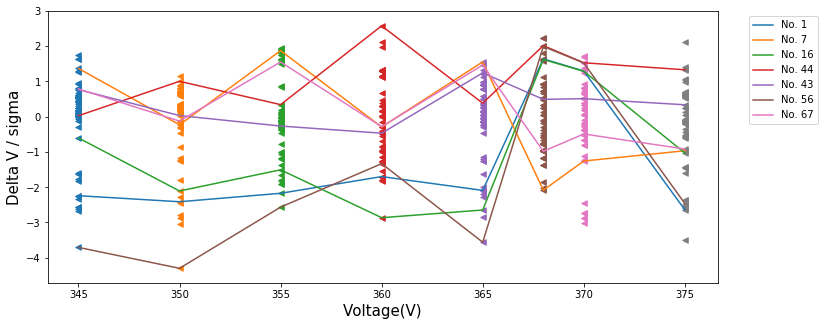

In [180]:
print('对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值')
v_list = [345,350,355,360,365,368,370,375]
plot_sigma(df_20190804_rcor, df_20190805_rcor, v_list, df1_charge_status=True, df2_charge_status=True, num_of_cells=92, \
           add_line_for_batt_num=[1,7,16,44,43,56,67])

对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值
20190804
20200517
dict_keys([345, 350, 355, 360, 365, 368, 370, 375])
dict_keys([345, 350, 355, 360, 365, 368, 370, 375])
0.012929946081929771
0.013569108337456563
0.014082887965179798
0.013557361528654903
0.010733459433594708
0.011268558290458358
0.011203493040962685
0.009689160838999997
{345: [43], 350: [43], 365: [43, 44], 368: [44], 370: [44]}


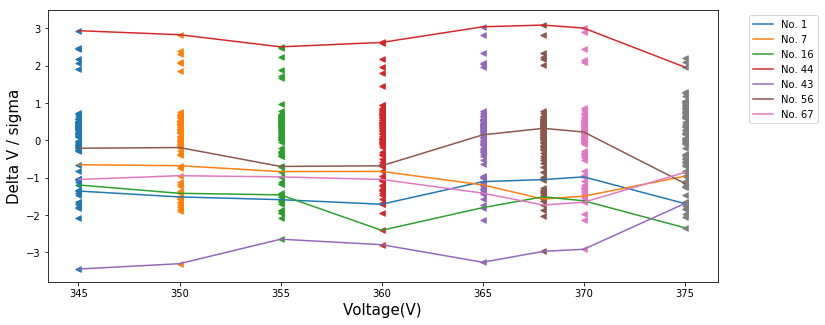

In [186]:
print('对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值')
v_list = [345,350,355,360,365,368,370,375]
plot_sigma(df_20190804_rcor, df_20200517_rcor, v_list, df1_charge_status=True, df2_charge_status=True, num_of_cells=92, \
           add_line_for_batt_num=[1,7,16,44,43,56,67])

In [296]:
def calc_r_for_cells(fvins_df, vin, day, veh_st):
    conds = (fvins_df.vin == vin) & (fvins_df.day == day) & (fvins_df.veh_st == 'D')
    sub_est_df = fvins_df[conds].copy()
    sub_est_df = sub_est_df.sort_values(by=['soc'], ascending=True)
    
    soc_range = sub_est_df['soc'].tolist()
    r_cells = {}
    for i in range(92):
        r_cells[i+1] = sub_est_df['r_cell_{}'.format(i+1)].tolist()
        
    return soc_range, r_cells 

In [276]:
def divide_by_int(r_cells_fit):
    new_r_cells_fit = r_cells_fit.copy()
    for key in new_r_cells_fit.keys():
        value = new_r_cells_fit[key]
        new_r_cells_fit[key] = [x / 1000 for x in value]
    return new_r_cells_fit

对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值
20190811
20190815
dict_keys([345, 350, 355, 360, 365, 368, 370, 375])
dict_keys([345, 350, 355, 360, 365, 368, 370, 375])
0.0016683368353147768
0.0022780180085641873
0.002804397929941524
0.002187957400027183
0.0017077901463704867
0.0016877153231481122
0.001959206375319204
0.0014532487724920322
{345: [16], 350: [16], 355: [16], 360: [7, 16, 67], 365: [7, 16, 67], 368: [16], 370: [16, 87, 89], 375: [16]}


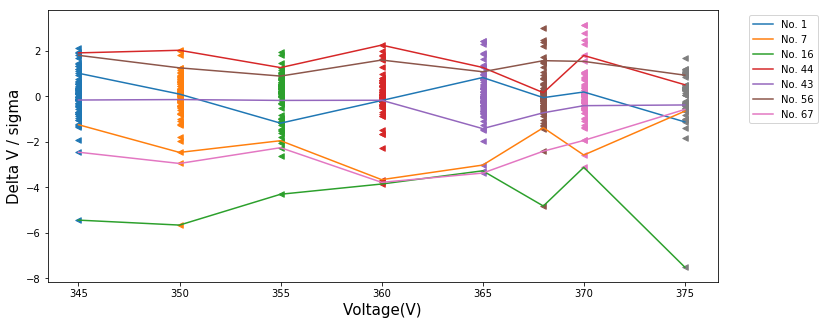

In [302]:
fig, ax = plt.subplots(figsize = [15, 7])
df_charge = charge_dic[12] # Index: 12, Date:20190811
soc_range, r_cells = calc_r_for_cells(fvins_df, 'LNAA2AA15K5001752', 20190811, 'D')
soc_range_fit, r_cells_fit = r_fit_for_soc(soc_range, r_cells)
r_cells_fit = divide_by_int(r_cells_fit)
print(soc_range, r_cells)
print(soc_range_fit, r_cells_fit)
df_20190811_rcor = v_vs_time_sigma(df_charge, num_of_cells=92, add_line_for_cell_num=[7,16,43,44,67], add_mv_avg=True, ratio=0.9, \
               rv_orig_lines=True, r_correct=[soc_range_fit, r_cells_fit], return_v=True)

fig, ax = plt.subplots(figsize = [15, 7])
df_charge = charge_dic[14] # Index: 14, Date:20190815
soc_range, r_cells = calc_r_for_cells(fvins_df, 'LNAA2AA15K5001752', 20190815, 'D')
soc_range_fit, r_cells_fit = r_fit_for_soc(soc_range, r_cells)
r_cells_fit = divide_by_int(r_cells_fit)
df_20190815_rcor = v_vs_time_sigma(df_charge, num_of_cells=92, add_line_for_cell_num=[7,16,43,44,67], add_mv_avg=True, ratio=0.9, \
               rv_orig_lines=True, r_correct=[soc_range_fit, r_cells_fit], return_v=True)

print('对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值')
v_list = [345,350,355,360,365,368,370,375]
plot_sigma(df_20190811_rcor, df_20190815_rcor, v_list, df1_charge_status=True, df2_charge_status=True, num_of_cells=92, \
           add_line_for_batt_num=[1,7,16,44,43,56,67])

对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值
20190811
20190815
dict_keys([345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373])
dict_keys([345, 347, 349, 351, 353, 355, 357, 359, 361, 363, 365, 367, 369, 371, 373])
0.0016683368353147768
0.0022628236123084164
0.002238820417130626
0.0020760961375620095
0.002257705075806884
0.002804397929941524
0.0029643808927277467
0.002603944223106159
0.0021754313478323495
0.0018817609182727698
0.0017077901463704867
0.001559399748938106
0.001661790795738339
0.001231156286110853
0.0015297848510510094
{345: [16], 347: [7, 16], 349: [7, 16], 351: [16], 353: [16], 355: [16], 357: [16], 359: [7, 16], 361: [7, 16, 67], 363: [67, 84], 365: [7, 16, 67], 367: [16, 90], 369: [16, 84, 89], 371: [16], 373: [16]}


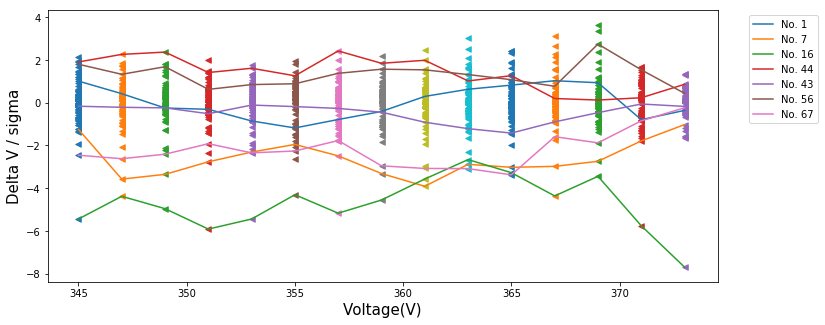

In [310]:
print('对比两个充电cycle在达到统一电压阈值时各个电池的电压差，找出电压差大于3*sigma的单个电池，记录电池的号码与发生时的电压阈值')
v_list = [345,347,349,351,353,355,357,359,361,363,365,367,369,371,373]
plot_sigma(df_20190811_rcor, df_20190815_rcor, v_list, df1_charge_status=True, df2_charge_status=True, num_of_cells=92, \
           add_line_for_batt_num=[1,7,16,44,43,56,67])